Michelle Hu  
---
University of Washington  
AMATH 563  
Homework 2  
Due: May 2, 2020  

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
wd = "/mnt/Backups/jmhu"

data_dir = wd + "/git_dirs/ComplexSystems_AMATH563/hw2/data/"
model_dir = wd + "/git_dirs/ComplexSystems_AMATH563/hw2/models/"
fig_dir = wd + "/git_dirs/ComplexSystems_AMATH563/hw2/figures/"
    
if not os.path.exists(data_dir):
    !mkdir $data_dir

if not os.path.exists(model_dir):
    !mkdir $model_dir

if not os.path.exists(fig_dir):
    !mkdir $fig_dir

In [4]:
df = pd.read_csv(data_dir+"population_data.csv"
                )

In [5]:
df.head()

,Year,Hare,Lynx
0,1845,20,32
1,1847,20,50
2,1849,52,12
3,1851,83,10
4,1853,64,13


### Question 1. Find best fit nonlinear, dynamical systems model to the data using sparse regression
nonlinear = not linear  
best = lowest error, highest accuracy  
sparse = fewest model terms, (L1 regularization)  

### Just do it the SINDY way

In [9]:
# dx1/dt = ax1 - bx1x2 + u^2
# dx2/dt = -cx2 + dx1x2
# with x1 = hare population
# and x2 = lynx population

x1=df.Hare.values
x2=df.Lynx.values

dx1=np.zeros_like(x1)
dx2=np.zeros_like(x2)
dt=2

for j in range(len(dx1)-1):
    if j == 0:
        pass
    else:
        dx1[j-1] = ( x1[j+1]-x1[j-1] ) / (2*dt)
        dx2[j-1] = ( x2[j+1]-x2[j-1] ) / (2*dt)
        
        
x1.shape, x2.shape, dx1.shape, dx2.shape

((30,), (30,), (30,), (30,))

In [10]:
# Toss endpoints
x1s=x1[1:-1]
x2s=x2[1:-1]
dx1=dx1[1:-1]
dx2=dx2[1:-1]

x1s.shape, x2s.shape, dx1.shape, dx2.shape

((28,), (28,), (28,), (28,))

In [69]:
# Create library of potential functions based on the 
A = np.array([ x1s, x2s, x1s**2, x1s*x2s, x2s**2, 
              x1s**3, x1s*x2s**2, x1s**2*x2s, x2s**3, 
              np.sin(x1s), np.cos(x2s), np.sin(x2s), np.cos(x1s), 
              np.sin(2*x1s), np.cos(2*x2s), np.sin(2*x2s), np.cos(2*x1s),
              1/np.sin(x1s), 1/np.cos(x2s), 1/np.sin(x2s), 1/np.cos(x1s) ])
A_names=["x1s", "x2s", "x1s**2", "x1s*x2s", "x2s**2", 
              "x1s**3", "x1s*x2s**2", "x1s**2*x2s", "x2s**3", 
              "np.sin(x1s)", "np.cos(x2s)", "np.sin(x2s)", "np.cos(x1s)", 
              "np.sin(2*x1s)", "np.cos(2*x2s)", "np.sin(2*x2s)", "np.cos(2*x1s)",
              "1/np.sin(x1s)", "1/np.cos(x2s)", "1/np.sin(x2s)", "1/np.cos(x1s)"]
A.shape, len(A_names)

((21, 28), 21)

### Use various solvers with L1 regularization to find function weights

In [197]:
%%time
# solve for vector xi (the weights/coefficients) using regression approach
# dx_dt = A @ xi

# Pseudoinverse
xi1_pinv=np.linalg.pinv(A.T) @ dx1
xi2_pinv=np.linalg.pinv(A.T) @ dx2
print(xi1_pinv.shape, xi2_pinv.shape)

from sklearn import linear_model

# LASSO
lasso=linear_model.Lasso(random_state=0, max_iter=100000)
lasso.fit(A.T, dx1)
xi1_lasso=lasso.coef_

lasso=linear_model.Lasso(random_state=0, max_iter=100000)
lasso.fit(A.T, dx2)
xi2_lasso=lasso.coef_
print(xi1_lasso.shape, xi2_lasso.shape)

# Least Angle Regression
lars = linear_model.LassoLars()#alpha=.1)
lars.fit(A.T, dx1)
xi1_lars=lars.coef_

lars = linear_model.LassoLars()#alpha=.1)
lars.fit(A.T, dx2)
xi2_lars=lars.coef_
print(xi1_lars.shape, xi2_lars.shape)

(21,) (21,)
(21,) (21,)
(21,) (21,)
CPU times: user 43.4 ms, sys: 3.98 ms, total: 47.3 ms
Wall time: 46.5 ms


In [201]:
# Set up candidate function tick names
A_names_sub=A_names[::2]
print(A_names_sub)

ticks=np.arange(len(A_names))
ticks=ticks[::2]
print(ticks)

['x1s', 'x1s**2', 'x2s**2', 'x1s*x2s**2', 'x2s**3', 'np.cos(x2s)', 'np.cos(x1s)', 'np.cos(2*x2s)', 'np.cos(2*x1s)', '1/np.cos(x2s)', '1/np.cos(x1s)']
[ 0  2  4  6  8 10 12 14 16 18 20]


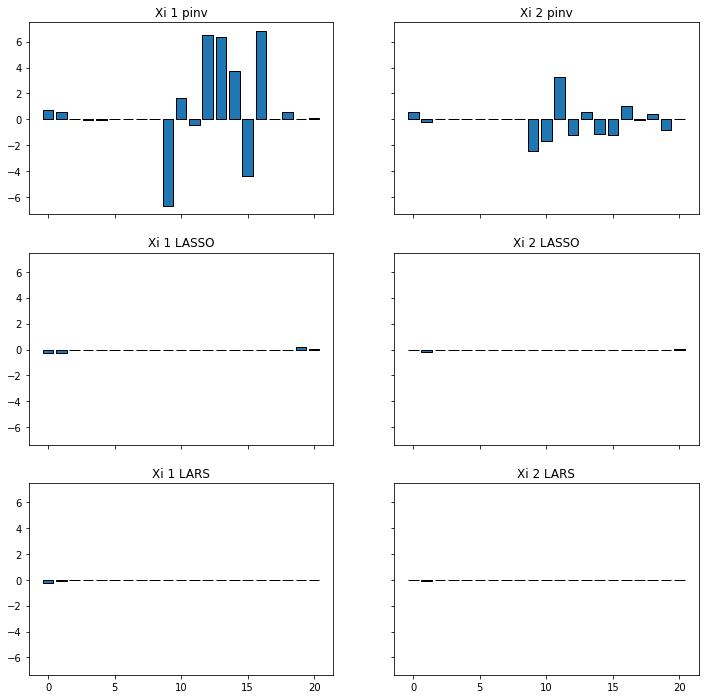

In [205]:
# Plot weightings of solutions
ec='k'

fig, ax = plt.subplots(3, 2, figsize=(12, 12), sharex=True, sharey=True)

# Xi 1 solutions
ax[0,0].bar(np.arange(len(A)), xi1_pinv, ec=ec)
ax[1,0].bar(np.arange(len(A)), xi1_lasso, ec=ec)
ax[2,0].bar(np.arange(len(A)), xi1_lars, ec=ec)
ax[0,0].set_title("Xi 1 pinv")
ax[1,0].set_title("Xi 1 LASSO")
ax[2,0].set_title("Xi 1 LARS")

# Xi 2 solutions
ax[0,1].bar(np.arange(len(A)), xi2_pinv, ec=ec)
ax[1,1].bar(np.arange(len(A)), xi2_lasso, ec=ec)
ax[2,1].bar(np.arange(len(A)), xi2_lars, ec=ec)
ax[0,1].set_title("Xi 2 pinv")
ax[1,1].set_title("Xi 2 LASSO")
ax[2,1].set_title("Xi 2 LARS");

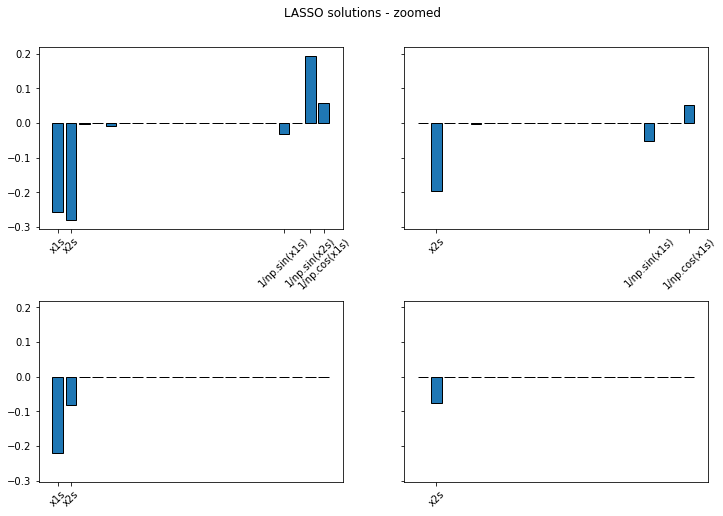

In [241]:
# Zoomed Lasso solutions
fig, ax = plt.subplots(2, 2, figsize=(12, 8), sharey=True)
plt.subplots_adjust(hspace=0.4)
ax[0,0].bar(np.arange(len(A)), xi1_lasso, ec=ec)
ax[1,0].bar(np.arange(len(A)), xi1_lars, ec=ec)

ax[0,1].bar(np.arange(len(A)), xi2_lasso, ec=ec)
ax[1,1].bar(np.arange(len(A)), xi2_lars, ec=ec)
plt.suptitle("LASSO solutions - zoomed", y=0.95);

### ==== Axis ticklabels === ###
thresh=0.02

# LASSO solutions
# First get indices of coefficients larger than threshold
# Then extract library candidate function names based on indices

xi1_lasso_ind=(np.indices(xi1_lasso.shape).squeeze())[np.abs(xi1_lasso)>thresh] 
xi1_names = [ A_names[x] for x in xi1_lasso_ind ] 
xi2_lasso_ind=(np.indices(xi2_lasso.shape).squeeze())[np.abs(xi2_lasso)>thresh]
xi2_names = [ A_names[x] for x in xi2_lasso_ind ]

# LARS solutions
xi1_lars_ind=(np.indices(xi1_lars.shape).squeeze())[np.abs(xi1_lars)>thresh]
xi1_lars_names = [ A_names[x] for x in xi1_lars_ind ]
xi2_lars_ind=(np.indices(xi2_lars.shape).squeeze())[np.abs(xi2_lars)>thresh]
xi2_lars_names = [ A_names[x] for x in xi2_lars_ind ]

rotation=45

ax[0,0].set_xticks(xi1_lasso_ind)
ax[0,0].set_xticklabels(xi1_names, rotation=rotation)

ax[0,1].set_xticks(xi2_lasso_ind)
ax[0,1].set_xticklabels(xi2_names, rotation=rotation);

ax[1,0].set_xticks(xi1_lars_ind)
ax[1,0].set_xticklabels(xi1_lars_names, rotation=rotation);

ax[1,1].set_xticks(xi2_lars_ind)
ax[1,1].set_xticklabels(xi2_lars_names, rotation=rotation);

In [242]:
# Print out thresholded LASSO solutions, LARS appears to destroy things too quickly
# LASSO solutions for xi1
print("xi1 indices:", xi1_lasso_ind)
print("xi1 (hares):", xi1_names)

# LASSO solutions for xi2
print("xi2 indices:", xi2_lasso_ind)
print("xi2 (lynx):", xi2_names)

xi1 indices: [ 0  1 17 19 20]
xi1 (hares): ['x1s', 'x2s', '1/np.sin(x1s)', '1/np.sin(x2s)', '1/np.cos(x1s)']
xi2 indices: [ 1 17 20]
xi2 (lynx): ['x2s', '1/np.sin(x1s)', '1/np.cos(x1s)']


### LASSO solution takeaways and checks
Hare population dependent on:
- hare population (x1, secant(x1)
- lynx population (x2, cosecant(x2))

Lynx population dependent on:
- lynx population (x2s) ==> negatively linear wth lynx pop (more lynx, slower growth)
- hare population (secant(x1), cosecant(x1)) ==> periodic with hare population

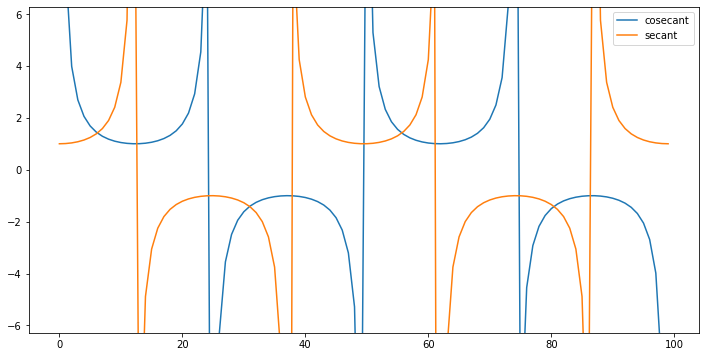

In [196]:
# Visualize secant and cosecant functions
fig, ax = plt.subplots(figsize=(12, 6))

q=np.linspace(-2*np.pi, 2*np.pi, 100)
ax.plot(1/np.sin(q), label="cosecant")
ax.plot(1/np.cos(q), label="secant")
ax.set_ylim(-2*np.pi,2*np.pi);
plt.legend()

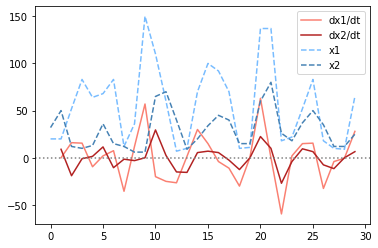

In [57]:
# Compute differences between temporal measurements
dx1=df.Hare.diff()
dx2=df.Lynx.diff()

# Compute time differences between temporal measurements
dt=df.Year.diff()

# Compute time derivatives --> this is vector b
dx1_dt=dx1.values/dt
dx2_dt=dx2.values/dt

plt.plot(dx1_dt, "salmon", label="dx1/dt")
plt.plot(dx2_dt, "firebrick", label="dx2/dt")

# plt.plot(dx)
plt.plot(x1, "--", c="dodgerblue", label="x1", alpha=0.6)
plt.plot(x2, "--", c="steelblue", label="x2")
plt.axhline(0, ls=':', c="grey")
plt.legend()

In [55]:
# # Reshape time derivatives
# dx1_dt=np.expand_dims(dx1_dt, 1)
# dx2_dt=np.expand_dims(dx2_dt, 1)
# print(dx1_dt.shape, dx2_dt.shape)

(30, 1) (30, 1)


Eigenvalue 1.0156991436948506: distance from unit circle 0.031644750502452856
Eigenvalue 0.014681503925691688: distance from unit circle 0.9997844534424799


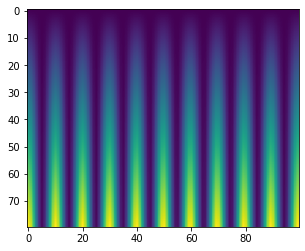

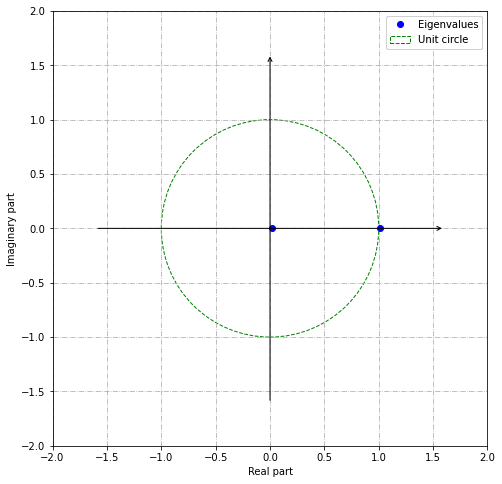

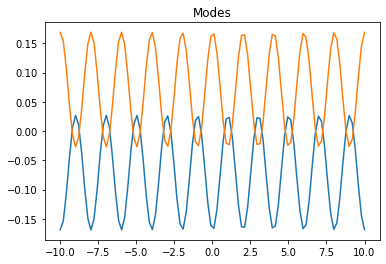

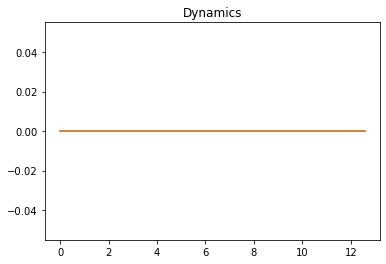

In [233]:
x=np.linspace(-10,10,100)
t=np.linspace(0,4*np.pi, 80)

[X, T]=np.meshgrid(x, t)

f1=(80*np.cos(np.pi*x)+75)*T  # hare
f2=(30*np.sin(np.pi*x-5)+40)*T # lynx
f=f1+f2

plt.imshow(f)

def f1(X,T):
    return((80*np.cos(np.pi*X)+75)*T)
def f2(X,T):
    return((30*np.sin(np.pi*X-5)+4)*T)

xgrid, tgrid = np.meshgrid(x, t)

X1 = f1(xgrid, tgrid)
X2 = f2(xgrid, tgrid)
X = X1 + X2


from pydmd import DMD
dmd = DMD(svd_rank=2)
dmd.fit(X.T)

for eig in dmd.eigs:
    print('Eigenvalue {}: distance from unit circle {}'.format(eig, np.abs(eig.imag**2+eig.real**2 - 1)))

dmd.plot_eigs(show_axes=True, show_unit_circle=True)

for mode in dmd.modes.T:
    plt.plot(x, mode.real)
    plt.title('Modes')
plt.show()

for dynamic in dmd.dynamics:
    plt.plot(t, dynamic.real)
    plt.title('Dynamics')
plt.show()

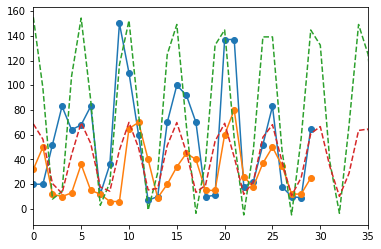

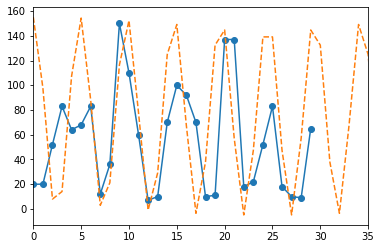

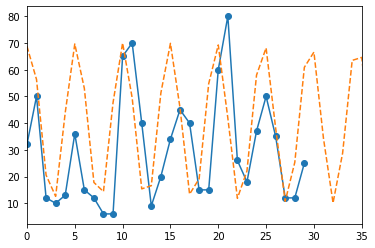

In [234]:
plt.figure(1)
df.Hare.plot(marker='o')
df.Lynx.plot(marker='o')

x=np.linspace(-10,10,50)

f1=80*np.cos(np.pi*x)+75
f2=30*np.sin(np.pi*x-5)+40

plt.plot(f1, "--")
plt.plot(f2, "--")

plt.xlim(0,35);


plt.figure(2)
df.Hare.plot(marker='o')
plt.plot(f1, "--")
plt.xlim(0,35);



plt.figure(3)
df.Lynx.plot(marker='o')
plt.plot(f2, "--")
plt.xlim(0,35);

### SVD and DMD two ways

(29, 29)


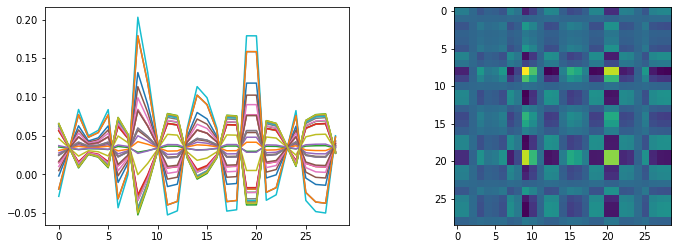

In [244]:
# From scratch with the hare population over time
arr=df.values[:, :2]
X=arr[:-1, :]
Xprime=arr[1:, :]

# Compute directly with observations because there are only 30
A = Xprime @ np.linalg.pinv(X)

print(A.shape)

fig, ax=plt.subplots(1,2, figsize=(12, 4))
ax[0].plot(A);
ax[1].imshow(A);

(29, 29) (29,) (29, 29)


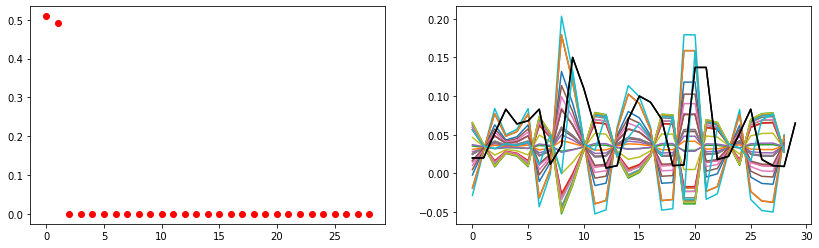

In [198]:
# Using SVD
u, s, v = np.linalg.svd(A)
print(u.shape, s.shape, v.shape)

# eigenvectors of AhA = rows of v
# eigenvectors of AAh = cols of u

# eigenvalues = s**2
fig, ax = plt.subplots(1,2, figsize=(14, 4))
ax[0].plot(np.diag(np.diagflat(s)/np.sum(np.diagflat(s))), "ro");

ax[1].plot(A);
(df.Hare/1000).plot(c="k", ax=ax[1])

ax[1].plot(np.diag(A));
(df.Hare/1000).plot(c="k")

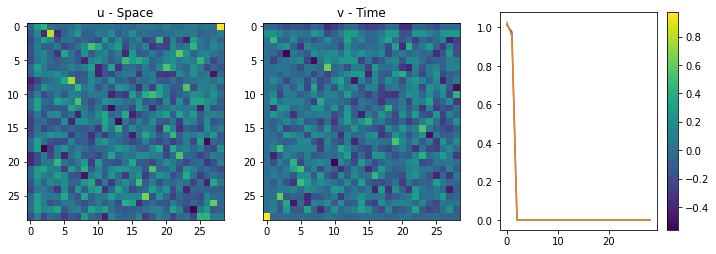

In [199]:
# Plot "space" and time components
fig, ax=plt.subplots(1, 3, figsize=(12, 4))
space=ax[0].imshow(u);
ax[0].set_title("u - Space")
time=ax[1].imshow(v);
ax[1].set_title("v - Time");
fig.colorbar(time);
ax[2].plot(s);
ax[2].plot(s**2)

Eigenvalue 1.0010682884980555: distance from unit circle 0.002137718236426167
Eigenvalue 0.2909960026105619: distance from unit circle 0.9153213264646738


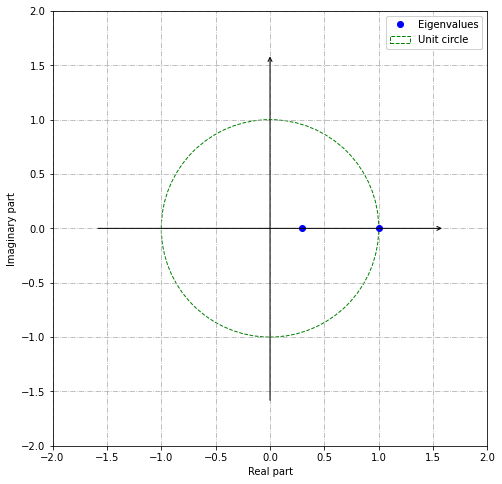

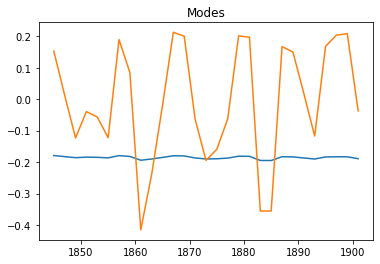

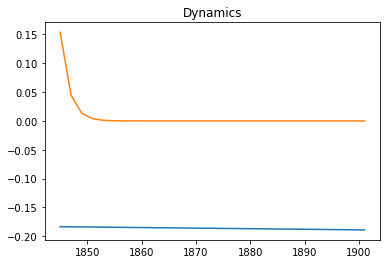

In [245]:
# Using DMD package
from pydmd import DMD

dmd = DMD(svd_rank=2)
dmd.fit(A)

for eig in dmd.eigs:
    print('Eigenvalue {}: distance from unit circle {}'.format(eig, np.abs(eig.imag**2+eig.real**2 - 1)))

dmd.plot_eigs(show_axes=True, show_unit_circle=True)

for mode in dmd.modes.T:
    plt.plot(df.Year.values[:-1], mode.real)
    plt.title('Modes')
plt.show()

for dynamic in dmd.dynamics:
    plt.plot(df.Year.values[:-1], dynamic.real)
    plt.title('Dynamics')
plt.show()

In [248]:
# compare eigenvalues?
print("SVD:", s[:2]**2)
print("DMD:", dmd.eigs.real)
print("Difference:",  s[:2]**2 - dmd.eigs.real)

SVD: [1.02688712 0.95379933]
DMD: [1.00106829 0.290996  ]
Difference: [0.02581883 0.66280333]


In [249]:
# DMD function from book
def DMD(X,Xprime,r):
    U,Sigma,VT = np.linalg.svd(X,full_matrices=0) # Step 1
    Ur = U[:,:r]
    Sigmar = np.diag(Sigma[:r])
    VTr = VT[:r,:]
    Atilde = np.linalg.solve(Sigmar.T,(Ur.T @ Xprime @ VTr.T).T).T # Step 2
    Lambda, W = np.linalg.eig(Atilde) # Step 3
    Lambda = np.diag(Lambda)
    
    Phi = Xprime @ np.linalg.solve(Sigmar.T,VTr).T @ W # Step 4
    alpha1 = Sigmar @ VTr[:,0]
    b = np.linalg.solve(W @ Lambda,alpha1)
    return Phi, Lambda, b

In [250]:
Phi, Lambda, b = DMD(X.T,Xprime.T,3)

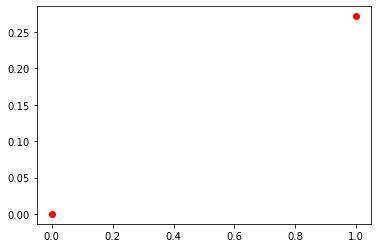

In [251]:
V2 = np.copy(np.real(Phi[:,1]))
V2=V2.T
minval = np.min(V2)
maxval = np.max(V2)

plt.plot(V2, "ro")

Eigenvalue (0.9904953470777571+0.1375462373797003j): distance from unit circle 6.661338147750939e-16
Eigenvalue (0.9935834726096825+0.11310120669950192j): distance from unit circle 7.771561172376096e-16


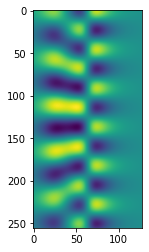

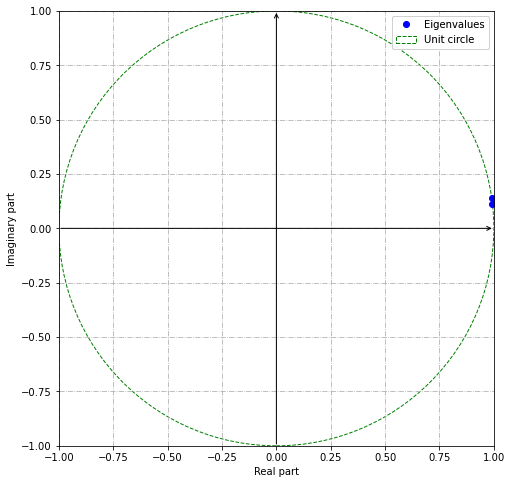

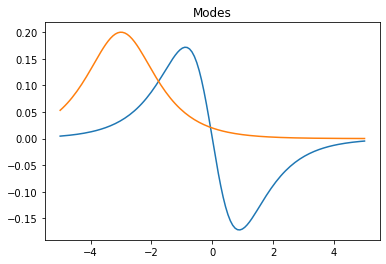

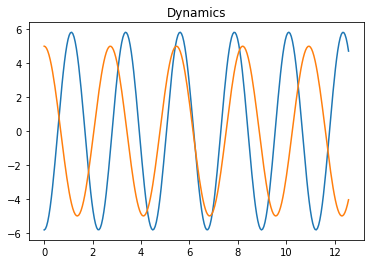

In [252]:
# Package DMD tutorial example
def f1(x,t): 
    return 1./np.cosh(x+3)*np.exp(2.3j*t)

def f2(x,t):
    return 2./np.cosh(x)*np.tanh(x)*np.exp(2.8j*t)

x = np.linspace(-5, 5, 128)
t = np.linspace(0, 4*np.pi, 256)

xgrid, tgrid = np.meshgrid(x, t)

X1 = f1(xgrid, tgrid)
X2 = f2(xgrid, tgrid)
X = X1 + X2

plt.imshow(X.real)

from pydmd import DMD
dmd = DMD(svd_rank=2)
dmd.fit(X.T)

for eig in dmd.eigs:
    print('Eigenvalue {}: distance from unit circle {}'.format(eig, np.abs(eig.imag**2+eig.real**2 - 1)))

dmd.plot_eigs(show_axes=True, show_unit_circle=True)

for mode in dmd.modes.T:
    plt.plot(x, mode.real)
    plt.title('Modes')
plt.show()

for dynamic in dmd.dynamics:
    plt.plot(t, dynamic.real)
    plt.title('Dynamics')
plt.show()

### Using SINDY

DMD the combined hare and lynx (sinusoidal model)  
2 first order differential equations like SINDY below

#### [SINDY](https://arxiv.org/pdf/1605.06682.pdf) *automatically* balances sparsity with model accuracy

authors said that SINDY + control worked better and SINDY alone  
dx/dt = f(x, u)

Lotka-Volterra Predator-Prey Model  
dx1/dt = ax1 - bx1x2 + u^2  
dx2/dt = -cx2 + dx1x2  
with x1 = hare population  
and x2 = lynx population

authros used u(t) = 2sin(t) + 2sin(t/10)  
using 100 timesteps (t) for training and 100 time steps (t) for validation

In [ ]:
# You're measuring x (x1 = hares, x2 = lynx)
# Maybe you're measuring the wrong variables, what about unknown variables y and z, (etc.)?

# x = first column
# y = second column
# z = third column

### Question 2. Compute KL divergence of the best model fit to the data
KL divergence = statistical metrix representing info lost when g(x) is used to represent f(x)

KL(f,g) = integral [ f(X,Beta) * log (f(X, Beta)/g(X, mu)) dX ]

[wiki](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence)  
[scipy implementation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html)  
see [mlm notes](https://machinelearningmastery.com/divergence-between-probability-distributions/) for discussion on kl_div() and rel_entr()  

### Question 3. Calculate AIC BIC scores for three of the best fit models

### Question 4. Time-delay embed the system and determine if latent variables exist

In [ ]:
# You're measuring x (x1 = hares, x2 = lynx)
# Maybe you're measuring the wrong variables, what about unknown variables y and z, (etc.)?

# x = first column
# y = second column
# z = third column
arr=df.values
x1=arr[:,1]

from scipy.linalg import hankel
# Shift matrix, construct Hankel matrix
H = hankel(x1)

# Take SVD of H
u, s, v = np.linalg.svd(H)
print(u.shape, s.shape, v.shape)

print(H.shape)

plt.plot(np.diag(np.diagflat(s)/np.sum(np.diagflat(s))), "ro");

# Probably need a longer timeseries...

---
## Part 2 - Belousov-Zhabotinsky data

### Question 1. Download data

In [ ]:
# courses.washington.edu/amath582/BZ.mat

### Question 2. Repeat questions 1 and 2 from Part 1 using this data.

### Question 1. Find best fit nonlinear, dynamical systems model to the data using sparse regression
nonlinear = not linear  
best = lowest error, highest accuracy  
sparse = fewest model terms, (L1 regularization)  

### Question 2. Compute KL divergence of the best model fit to the data
KL divergence = statistical metrix representing info lost when g(x) is used to represent f(x)